# <span style="color:skyblue;"> Transformer를 활용해 챗봇 만들기</span>

한국어 Q&A 대화문 데이터 corpus를 활용하여 질문에 대한 답변 태스크를 수행

데이터 출처 : [songys/Chatbot_data](https://github.com/songys/Chatbot_data/ChatbotData.csv)

<span style='color:skyblue;'> **모델 : Encoder-Decoder Transformer**</span>

도입한 것 : 같은 하이퍼파라미터를 갖는 모델을 여러 시드로 초기화해서 얼마나 데이터 학습 분포가 촘촘한지 확인해보자.

&rightarrow; seed_list = [20, 21, 22, 25, 28, 29, 6] 에 대해서 Learning Curve분포를 시각화, 



## <span style="color:skyblue;"> Result (at its worst) </span>
| Average Blue Score | Train data(num=100) | Custom Dialogue(num=10) |
|----------|----------|----------|
| 증강 적용(5배, Lexical, Random Ins/Del) | <span style="color:skyblue;"> 64.56 </span>| <span style="color:skyblue;"> 1.52 </span> |
| 증강 미적용 | 36.1 | 1.22 |

### Custom Dialogues

    example = ['지루하다, 놀러가고 싶어.',
               '오늘 일찍 일어났더니 피곤하다.',
               '간만에 여자친구랑 데이트 하기로 했어.',
               '집에 있는다는 소리야.',
               '배고픈데 뭐 먹을지 고민되네.',
               '비가 와서 그런가 기분이 좀 별로야.',
               '시험 공부해야 하는데 집중이 안 돼.',
               '드라마 정주행 시작했는데 완전 내 스타일!',
               '운동 갔다 왔더니 몸이 너무 아파.',
               '주말인데 할 일이 너무 많아서 귀찮다.']

    example_answers = ['같이 놀면 좋겠어요',
                       '조금 더 잠 들어요',
                       '좋은 날이 되겠네요',
                       '방 청소를 하면 되겠네',
                       '뭐라도 드세요',
                       '감성적이기에 딱 좋죠',
                       '딴 생각 하지 마세요',
                       '드라마 완전 재밌나 봐요',
                       '몸이 놀라서 그래',
                       '주말에도 일 하느라 힘들겠다']

### Example에 대한 모델 대화 출력 예시(Run 1)

    Average BLEU score: 1.5223969964279502 점, [0,1] 단위에 100 곱함

    Example Sentence: 지루하다, 놀러가고 싶어.
    Output Sequence:  저 도 마음 가짐 에 있 어요 
    Example Answers: 같이 놀 면 좋 겠 어요
    Bleu Score: 3.3031643180138064

    Example Sentence: 오늘 일찍 일어났더니 피곤하다.
    Output Sequence:  개인 바쁜가 봐요 
    Example Answers: 조금 더 잠 들 어요
    Bleu Score: 0
    
    Example Sentence: 간만에 여자친구랑 데이트 하기로 했어.
    Output Sequence:  좋 은 만남 이 네요 
    Example Answers: 좋 은 날 이 되 겠 네요
    Bleu Score: 9.057365499736145
    
    Example Sentence: 집에 있는다는 소리야.
    Output Sequence:  좋 은 분 하 실 거 예요 
    Example Answers: 방 청소 를 하 면 되 겠 네
    Bleu Score: 2.8634401465295497
    
    Example Sentence: 배고픈데 뭐 먹을지 고민되네.
    Output Sequence:  예쁘 게 먹 고 는 걸 수 도 있 어요 
    Example Answers: 뭐 라도 드세요
    Bleu Score: 0
    
    Example Sentence: 비가 와서 그런가 기분이 좀 별로야.
    Output Sequence:  비 와 당신 는데 
    Example Answers: 감성 적 이 기에 딱 좋 죠
    Bleu Score: 0
    
    Example Sentence: 시험 공부해야 하는데 집중이 안 돼.
    Output Sequence:  잠시 쉬 어도 습니다 
    Example Answers: 딴 생각 하 지 마세요
    Bleu Score: 0
    
    Example Sentence: 드라마 정주행 시작했는데 완전 내 스타일!
    Output Sequence:  속 조금 후련 해졌 죠 
    Example Answers: 드라마 완전 재밌 나 봐요
    Bleu Score: 0
    
    Example Sentence: 운동 갔다 왔더니 몸이 너무 아파.
    Output Sequence:  건강 에 네요 
    Example Answers: 몸 이 놀라 서 그래
    Bleu Score: 0
    
    Example Sentence: 주말인데 할 일이 너무 많아서 귀찮다.
    Output Sequence:  은가 봐요 
    Example Answers: 주말 에 도 일 하 느라 힘들 겠 다
    Bleu Score: 0

### Model Hyperparameter: 
    
    config = {
    "n_layers": 3,
    "d_model": 256,
    "n_heads": 4,
    "d_ff": 1024,
    "dropout": 0.5,
    "vocab_size": 15000,
    "pos_len": 50,
    "batch_size": 32,
    "epochs": 20
    }
___


## 오늘의 이슈: 서브클래싱 한 트랜스포머를 새롭게 빌드해도 기존의 변수를 가지고 학습을 진행하는 이유는 무엇일까?

1. 아마 @tf.function() 데코레이터가 처음 호출될 때의 변수를 캡쳐하고 캐시하기 때문?
2. 이럼 GPU 연산 최적화가 깨질 수 있으니 각 run마다 train_step을 재정의 한다

해결: train_step이 @tf.function으로 데코레이팅 되어 있는데, 캐싱이 최초 정보만 되어있어서 계속 그 값으로 학습하는 것이였음

&rightarrow; get_train_step으로 포장해서 train_step을 매 번 새롭게 정의해서 초기화 해주면 된다.

    def get_train_step():
        @tf.function()
        def train_step(src, tgt, model, optimizer):
            gold = tgt[:, 1:]
            
            enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)
    
            # 계산된 loss에 tf.GradientTape()를 적용해 학습 진행
            with tf.GradientTape() as tape:
                predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
                loss = loss_function(gold, predictions[:, :-1])
    
            # 최종적으로 optimizer.apply_gradients()가 사용
            variables = model.trainable_variables
            gradients = tape.gradient(loss, variables)
            optimizer.apply_gradients(zip(gradients, variables))
            
            return loss, enc_attns, dec_attns, dec_enc_attns
        return train_step`

### 데이터 준비과정
1. 라이브러리 로드
2. 전처리 및 Mecab 토크나이징
3. Data Augmentation
4. 패딩

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re
import os
import io
import time
import random
import seaborn as sns
import math
import nltk

from konlpy.tag import Mecab

import asyncio
from googletrans import Translator

from gensim.models.word2vec import Word2Vec

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

from tqdm.notebook import tqdm

C:\Anaconda3\envs\tf\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
filepath = "./ChatbotData.csv"

raw_data = pd.read_csv(filepath)

raw_data.dropna(inplace=True)
raw_data.drop_duplicates(inplace=True)

#### 중복이 존재하는 것을 확인
&rightarrow; 미리 제거하자.

In [3]:
raw_data.head(100)          

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
95,개학하니까 좋다,친구들이 보고싶었나봐요.,0
96,걔 너무 싫다,되도록 만나지 마세요.,0
97,걔는 누굴 닮아서 그런거니?,당신이요.,0
98,걔랑 같은 반 됐으면 좋겠다,당신의 운을 믿어보세요.,0


In [4]:
# Q, A 분리
questions = list(raw_data['Q'])
answers = list(raw_data['A'])

In [5]:
def preprocess_sentence(sentence, s_token=False, e_token=False):   
    # 소문자 변환
    sentence = sentence.lower().strip()

    # 정규식 활용
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!\s]+", " ", sentence)

    sentence = " ".join(sentence.split())
    
    """
    # Mecab 이후에 후처리로 answer에는 다시 적용할 예정이므로 지금은 적용 X
    if s_token:
        sentence = "<s> " + sentence
    if e_token:
        sentence += " </s>"
    """
    return sentence

In [6]:
mecab = Mecab(dicpath = 'C:/Mecab/mecab-ko-dic')

#### 데이터 전처리, 중복 제거, 토크나이징

상위 90퍼 길이에서 자르기

In [7]:
def build_corpus(questions, answers):
    
    # 1. 전처리
    preprocessed_questions = [preprocess_sentence(x) for x in questions]
    preprocessed_answers = [preprocess_sentence(x) for x in answers]
    
    # 2. 중복 제거(하나만 남김)
    unique_q = set()
    unique_a = set()
    filtered_pairs = []
    
    for q, a in zip(preprocessed_questions, preprocessed_answers):
        if q not in unique_q and a not in unique_a:
            filtered_pairs.append((q, a))
            unique_q.add(q)
            unique_a.add(a)
    
    filtered_questions, filtered_answers = zip(*filtered_pairs) if filtered_pairs else ([], [])
    
    filtered_questions = list(filtered_questions)
    filtered_answers = list(filtered_answers)
    
    # 3. Mecab 토크나이징
    tokenized_questions = [mecab.morphs(x) for x in filtered_questions]
    tokenized_answers= [mecab.morphs(x) for x in filtered_answers]
    
    # 4 . N 이하의 토큰 길이를 갖는 쌍만 남기기
    print('Question 상위 90퍼 길이:', np.percentile([len(x) for x in tokenized_questions], 90))
    print('Answer 상위 90퍼 길이:', np.percentile([len(x) for x in tokenized_answers], 90))
    
    N_q = round(np.percentile([len(x) for x in tokenized_questions], 80))
    N_a = round(np.percentile([len(x) for x in tokenized_answers], 80))
    N = min(N_q, N_a)

    
    filtered_indices = [i for i in range(len(tokenized_questions)) if len(tokenized_questions[i]) <= N and len(tokenized_answers[i]) <= N]
    
    que_corpus = [tokenized_questions[i] for i in filtered_indices]
    ans_corpus = [tokenized_answers[i] for i in filtered_indices]  
    
    return que_corpus, ans_corpus

In [8]:
que_corpus, ans_corpus = build_corpus(questions, answers)
print(len(que_corpus), len(ans_corpus))

Question 상위 90퍼 길이: 13.0
Answer 상위 90퍼 길이: 13.0
4954 4954


In [9]:
que_corpus[0]

['12', '시', '땡', '!']

In [10]:
len(que_corpus)

4954

In [11]:
ans_corpus[0]

['하루', '가', '또', '가', '네요', '.']

#### Data Augmentation

Pre-trained embedding : Word2Vec, [Kyubyong/wordvectors/korean (w)](https://github.com/Kyubyong/wordvectors)

임베딩에서 most_similar 메서드를 활용해 lexical substitution 방식으로 증강

&rightarrow; 아마 다른 방식을 더 활용해 방대한 데이터를 확보해야 할듯
- random insertion/deletion

In [12]:
embedding_path = "C:/datasets_temp/ko.bin"

wv = Word2Vec.load(embedding_path)
print(type(wv))

<class 'gensim.models.word2vec.Word2Vec'>


In [13]:
def lexical_sub(wv, que_corpus, ans_corpus, do_lex=True):
    def substitute(sentence_tokens):
        # valid_tokens: 단어가 모델의 어휘에 있는지 확인 (빈 리스트일 경우 원본 반환)
        valid_tokens = [t for t in sentence_tokens if t in wv.wv.vocab]
        if not valid_tokens:
            return sentence_tokens
        
        chosen = random.choice(valid_tokens)
        new_tokens = []
        # 전체 문장을 순회하면서, chosen 단어를 유사 단어로 치환
        for token in sentence_tokens:
            if token == chosen:
                similar_word = wv.wv.most_similar(token)[0][0]
                new_tokens.append(similar_word)
            else:
                new_tokens.append(token)
        return new_tokens

    # 1. 원본 쌍
    final_que = list(que_corpus)
    final_ans = list(ans_corpus)
    
    if do_lex:
        # 2. 질문만 증강
        aug_que = [substitute(q_tokens) for q_tokens in que_corpus]
        final_que.extend(aug_que)
        final_ans.extend(ans_corpus)
    
        # 3. 답변만 증강
        aug_ans = [substitute(a_tokens) for a_tokens in ans_corpus]
        final_que.extend(que_corpus)
        final_ans.extend(aug_ans)

    return final_que, final_ans


In [14]:
def random_deletion(corpus, deletion_prob=0.1):
    """
    각 문장에서 각 토큰을 deletion_prob 확률로 삭제합니다.
    만약 삭제 후 문장이 빈 리스트가 되면 원본 문장을 그대로 반환
    """
    new_corpus = []
    for tokens in corpus:
        new_tokens = [token for token in tokens if random.random() > deletion_prob]
        if not new_tokens:
            new_tokens = tokens
        new_corpus.append(new_tokens)
    return new_corpus

In [15]:
def random_insertion(corpus, wv, insertion_prob=0.1):
    """
    각 문장에서 각 토큰에 대해 insertion_prob 확률로,
    해당 토큰의 유사 단어(Word2Vec)를 찾아 임의의 위치에 삽입
    """
    new_corpus = []
    for tokens in corpus:
        new_tokens = tokens.copy()
        for token in tokens:
            if token in wv.wv.vocab and random.random() < insertion_prob:
                try:
                    synonym = wv.wv.most_similar(token)[0][0]
                    pos = random.randint(0, len(new_tokens))
                    new_tokens.insert(pos, synonym)
                except Exception:
                    pass
        new_corpus.append(new_tokens)
    return new_corpus

In [16]:
def augmentation(wv, que_corpus, ans_corpus):
    """
    여러 증강 기법(lexical substitution, back translation)을 병렬로 적용하여
    전체 증강 데이터를 생성
    """
    # Lexical substitution
    lexical_que, lexical_ans = lexical_sub(wv, que_corpus, ans_corpus, do_lex=True)
    
    # Random deletion
    rd_que = random_deletion(que_corpus, deletion_prob=0.1)
    rd_ans = random_deletion(ans_corpus, deletion_prob=0.1)
    
    # Random insertion
    ri_que = random_insertion(que_corpus, wv, insertion_prob=0.1)
    ri_ans = random_insertion(ans_corpus, wv, insertion_prob=0.1)
    
    # 각 기법의 결과를 합칩니다.
    final_que = lexical_que + rd_que + ri_que
    final_ans = lexical_ans + rd_ans + ri_ans
    
    return final_que, final_ans

In [17]:
augmented_questions, augmented_answers = augmentation(wv, que_corpus, ans_corpus)

In [18]:
print(len(augmented_questions), len(augmented_answers))

24770 24770


In [19]:
augmented_answers = [["<start>"] + data + ["<end>"] for data in augmented_answers]
print(augmented_answers[0])

['<start>', '하루', '가', '또', '가', '네요', '.', '<end>']


#### 정수 인덱싱 하고 패딩처리

In [20]:
all_texts = [" ".join(tokens) for tokens in augmented_questions + augmented_answers]
all_texts[-10:]

['<start> 결심 은 빠르 면 빠를수록 좋 아요 . <end>',
 '<start> 법 적 부부 가 된 걸 놀드 축하 해요 ! <end>',
 '<start> 외로운 상태 인 거 같 아요 . <end>',
 '<start> 적극 적 으로서 으로 꼬셔 강력히 보 세요 . <end>',
 '<start> 손수건 준비 할게요 . <end>',
 '<start> 힘들 겠 지만 제게 말 ㅂ시오 해 보 세요 . <end>',
 '<start> 화끈 하 시 네요 . <end>',
 '<start> 설렜 을 텐데 안타깝 아쉽 겠 어요 . <end>',
 '<start> 진심 으로 다가가 보 세요 . <end>',
 '<start> 는데요 설렜 겠 어요 는데 . <end>']

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_texts)

augmented_questions_seq = tokenizer.texts_to_sequences([" ".join(tokens) for tokens in augmented_questions])
augmented_answers_seq   = tokenizer.texts_to_sequences([" ".join(tokens) for tokens in augmented_answers])


In [22]:
augmented_answers_seq[:3]

[[1, 264, 7, 93, 7, 30, 2],
 [1, 690, 11, 1156, 2],
 [1, 286, 14, 560, 17, 24, 2]]

In [23]:
print(tokenizer.index_word[1], tokenizer.index_word[2])

start end


In [24]:
# 패딩 처리; enc_train, dec_train
N = 13 + 2 + 2

enc_train = tf.keras.preprocessing.sequence.pad_sequences(augmented_questions_seq, maxlen=N, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(augmented_answers_seq, maxlen=N, padding='post')

print("enc_train shape:", enc_train.shape)
print("dec_train shape:", dec_train.shape)

enc_train shape: (24770, 17)
dec_train shape: (24770, 17)


### 트랜스포머 모델 준비
1. 포지셔널 인코딩, 멀티헤드 어텐션, 피드포워드 네트워크 준비
2. 마스킹 구현
3. 인코더, 디코더 및 트랜스포머 클래스 구현
4. 인코더, 디코더 레이어 준비
5. 손실함수, 옵티마이저 등의 베이스 컨피그
6. Train, Test 스텝 정의

In [25]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [26]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)\
    
    dec_lookahead_mask = generate_causality_mask(tf.shape(tgt)[1])    
    dec_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_lookahead_mask, dec_padding_mask)
    
    dec_enc_mask = generate_padding_mask(src)
    return enc_mask, dec_mask, dec_enc_mask

In [27]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        scaled_qk = tf.matmul(Q, K, transpose_b=True) / tf.math.sqrt(d_k)

        if mask is not None: 
            scaled_qk += (mask * -1e9) 

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions

    def split_heads(self, x):
        
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0,2,1,3])

        return split_x

    def combine_heads(self, x):
        
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0,2,1,3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))
        
        return combined_x
    

    def call(self, Q, K, V, mask):
        
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_split = self.split_heads(WQ)
        WK_split = self.split_heads(WK)
        WV_split = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(WQ_split, WK_split, WV_split, mask)
        
        out = self.combine_heads(out)
        
        out = self.linear(out)
        
        return out, attention_weights

In [28]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [29]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Encoder Multi-Head Attention
        플로우: x -> LayerNorm -> MultiHeadAttention -> Dropout -> Add
        
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        플로우: -> LayerNorm -> FFN -> Dropout -> Add
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [30]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.masked_self_attn = MultiHeadAttention(d_model, n_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        플로우: x -> LayerNorm -> Causality-Masked Self MultiHeadAttention -> Dropout -> Add
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.masked_self_attn(out, out, out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Encoder-Decoder Multi-Head Attention
        플로우: -> LayerNorm -> Encoder-Decoder MultiHeadAttention -> Dropout -> Add
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        플로우: -> LayerNorm -> FFN -> Dropout -> Add        
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, dec_attn, dec_enc_attn

In [31]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [32]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [33]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 vocab_size,
                 pos_len=50,
                 dropout=0.2,
                 shared_fc=True,
                 shared_emb=False):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        
        if shared_emb:
            self.enc_embedding = self.dec_embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        else:
            self.enc_embedding = tf.keras.layers.Embedding(vocab_size, d_model)
            self.dec_embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        
        self.pos_encoding = positional_encoding(pos_len, d_model)
        
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        self.output_linear = tf.keras.layers.Dense(vocab_size)
        
        self.shared_fc = shared_fc
        if shared_fc:
            self.output_linear.set_weights(tf.transpose(self.dec_embedding.weights))
                    
        self.dropout = tf.keras.layers.Dropout(dropout)

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)
        
        if self.shared_fc:
            out *= tf.math.sqrt(self.d_model)
            
        out += self.pos_encoding[np.newaxis, ...][:,:seq_len, :]
        
        ## 드랍아웃 추가
        out = self.dropout(out)
        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_mask, dec_enc_mask):
        """
        1. 인코더-디코더 구성
        2. 인코더에서 output과 attention 계산 후 디코더에 넘김
        3. 디코더에서 masked self attention과 encoder-decoder multihead attention 계산
        4. FFN
        """
        enc_in_emb = self.embedding(self.enc_embedding, enc_in)
        dec_in_emb = self.embedding(self.dec_embedding, dec_in)
        
        enc_output, enc_attns = self.encoder(enc_in_emb, enc_mask)
        
        dec_output, dec_attns, dec_enc_attns = self.decoder(dec_in_emb, enc_output, dec_mask, dec_enc_mask)
        
        logits = self.output_linear(dec_output)    
        
        return logits, enc_attns, dec_attns, dec_enc_attns

### 컴파일 도구들

LR 스케줄러, 손실함수와 옵티마이저

In [34]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [35]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### 훈련과 검증, 그리고 평가 단계

In [36]:
def get_train_step():
    @tf.function()
    def train_step(src, tgt, model, optimizer):
        gold = tgt[:, 1:]
        
        enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

        # 계산된 loss에 tf.GradientTape()를 적용해 학습 진행
        with tf.GradientTape() as tape:
            predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
            loss = loss_function(gold, predictions[:, :-1])

        # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        
        return loss, enc_attns, dec_attns, dec_enc_attns
    return train_step

In [37]:
@tf.function()
def test_step(src, tgt, model):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
    loss = loss_function(gold, predictions[:, :-1])
    
    return loss

In [38]:
def evaluate(sentence, model, max_length=N):
    """
    1. 입력 문장 전처리 및 토크나이징, 패딩 해서 인코더에 넣을 준비
    """
    tokens = mecab.morphs(preprocess_sentence(sentence))
    token_ids = tokenizer.texts_to_sequences([" ".join(tokens)])[0]
    enc_input = tf.keras.preprocessing.sequence.pad_sequences(
        [token_ids], maxlen=max_length, padding='post'
    )

    """
    2. 디코딩 하기 위해서 bos 토큰만 초기값으로 설정
    """
    
    output = tf.constant([[1]], dtype=tf.int32)

    for i in range(dec_train.shape[-1]):
        enc_mask, dec_mask, dec_enc_mask = generate_masks(enc_input, output)
        predictions, enc_attns, dec_attns, dec_enc_attns = model(
            enc_input,
            output,
            enc_mask,
            dec_mask,
            dec_enc_mask
        )

        predicted_id = tf.argmax(predictions[0, -1]).numpy().item()
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
        """
        predicted_token = en_tokenizer.id_to_piece(predicted_id)

        print(f"Step {i}: predicted_id = {predicted_id}, token = {predicted_token}")
        """
                   
        # eos token이 예측되면 종료
        if predicted_id == 2:
            break

    result = tokenizer.sequences_to_texts(output.numpy().tolist())[0]
    
    return result

def translate(sentence, model, show_result=True):
    result = evaluate(sentence, model)
    tokens = ['start', 'end']
    for t in tokens:
        result = result.replace(t, "")
    
    if show_result:
        print('Input: %s' % sentence)
        print('Predicted translation: {}'.format(result))
    return result

In [39]:
def train(train_dataset, test_dataset, example):
    train_loss_history = []
    val_loss_history = []

    for epoch in range(EPOCHS):
    
        # Training Loop
        total_train_loss = 0
        train_steps = 0

        progress_bar = tqdm(train_dataset, desc=f"Epoch {epoch+1} Train", leave=False)
        for src_batch, tgt_batch in progress_bar:
            loss, _, _, _ = train_step(src_batch, tgt_batch, transformer, optimizer)
        
            total_train_loss += loss
            train_steps += 1

            avg_train_loss = total_train_loss / train_steps
            progress_bar.set_postfix({"loss": f"{avg_train_loss:.4f}"})
        
        train_loss_history.append(avg_train_loss.numpy())
    
        # Validation Loop
        total_val_loss = 0
        val_steps = 0
    
        progress_bar_val = tqdm(test_dataset, desc=f"Epoch {epoch+1} Val", leave=False)
        for src_batch, tgt_batch in progress_bar_val:
            loss = test_step(src_batch, tgt_batch, transformer)
        
            total_val_loss += loss
            val_steps += 1
            
            avg_val_loss = total_val_loss / val_steps
            progress_bar_val.set_postfix({"val_loss": f"{avg_val_loss:.4f}"})
        
        val_loss_history.append(avg_val_loss.numpy())
    
        print(f"\nEpoch {epoch+1} - Train Loss: {avg_train_loss:.4f} / Val Loss: {avg_val_loss:.4f}")
    
    return train_loss_history, val_loss_history

### 기타 도구들

- Learning Curve 시각화
- BLEU score 계산(일반화 데이터에 대해)

BLEU score를 train data에 대해서 계산하면 아무래도 높을 수 밖에 없을 거 같긴 한데... 그 것도 해야하나? 

In [40]:
def plot_learning_curves(all_train_loss, all_val_loss):
    """
    여러 번의 학습 run에서 수집된 Train/Val Loss를
    평균 곡선과 표준편차 음영으로 플롯
    """
    n_runs = len(all_train_loss)
    epochs = len(all_train_loss[0])
    epoch_range = np.arange(1, epochs+1)
    
    mean_train = np.mean(all_train_loss, axis=0)
    std_train = np.std(all_train_loss, axis=0)
    mean_val = np.mean(all_val_loss, axis=0)
    std_val = np.std(all_val_loss, axis=0)
    
    print("Train Std:", std_train)
    print("Validation Std:", std_train)
    
    plt.figure(figsize=(10,6))
    
    # 개별 run의 곡선 (투명하게)
    for i in range(n_runs):
        plt.plot(epoch_range, all_train_loss[i], color='blue', alpha=0.3)
        plt.plot(epoch_range, all_val_loss[i], color='orange', alpha=0.3)
    
    # 평균 곡선
    plt.plot(epoch_range, mean_train, color='blue', label='Train Loss (mean)', linewidth=0.5)
    plt.plot(epoch_range, mean_val, color='orange', label='Val Loss (mean)', linewidth=0.5)
    
    # 표준편차 음영
    plt.fill_between(epoch_range, mean_train-std_train, mean_train+std_train, color='blue', alpha=0.2)
    plt.fill_between(epoch_range, mean_val-std_val, mean_val+std_val, color='orange', alpha=0.2)
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Learning Curve Distribution over Multiple Runs")
    plt.legend()
    plt.grid(True)
    plt.show()

In [41]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1)

def eval_bleu(source_sentences, target_sentences, show_bleu_only=False):
    """
    절차:
      1) source_sentences[i] -> translate(...) -> 모델 예측 출력 (형태소 구분된 문자열)
      2) 예측 결과(candidate_text)를 split()으로 토큰화
      3) target_sentences[i]를 mecab.morphs()로 토큰화 (reference_tokens)
      4) calculate_bleu()로 BLEU 점수를 구해 리스트에 저장
      5) 최종적으로 문장별 BLEU 점수 리스트와 평균값을 반환
    """
    bleu_scores = []

    for i, src_text in enumerate(source_sentences):
        # 1) 모델을 이용해 예측 텍스트(형태소 분석 형태) 생성
        
        candidate_text = translate(src_text, transformer, show_result=False)
        
        # 예: "잘 하 지 않 겠 네요"

        # 2) 후보 문장 토큰화
        candidate_tokens = candidate_text.split()

        # 3) 정답 문장도 mecab으로 형태소 분석
        reference_text = target_sentences[i]
        reference_tokens = mecab.morphs(reference_text)
        
        # 4) BLEU 점수 계산
        score = calculate_bleu(reference_tokens, candidate_tokens)
        bleu_scores.append(score)
        
        if show_bleu_only:
            continue
        else:
            print("Example Sentence:", src_text)
            print("Output Sequence:", candidate_text)
            print("Example Answers:", ' '.join(reference_tokens))
            print("Bleu Score:", score)
            print("")

    # 모든 문장에 대한 BLEU 평균
    avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0.0
    print("Average BLEU score:", avg_bleu * 100, "점")
    return avg_bleu

### 시행

#### 트랜스포머 빌드

In [42]:
def build_transformer_model(config):
    """
    config 딕셔너리에 정의된 하이퍼파라미터를 바탕으로
    새로운 Transformer 모델과 옵티마(optimizer)를 생성하여 반환.
    """
    # 모델 생성
    transformer = Transformer(
        n_layers=config["n_layers"],
        d_model=config["d_model"],
        n_heads=config["n_heads"],
        d_ff=config["d_ff"],
        vocab_size=config["vocab_size"],
        pos_len=config["pos_len"],
        dropout=config["dropout"],
        shared_emb=True
    )
    
    # 학습률 스케줄러 및 옵티마 설정
    learning_rate = LearningRateScheduler(config['d_model'])
    optimizer = tf.keras.optimizers.Adam(
        learning_rate,
        beta_1=0.9,
        beta_2=0.98,
        epsilon=1e-9
    )
    return transformer, optimizer

In [43]:
config = {
    "n_layers": 3,
    "d_model": 256,
    "n_heads": 4,
    "d_ff": 1024,
    "dropout": 0.5,
    "vocab_size": 15000,
    "pos_len": 50,
    "batch_size": 32,
    "epochs": 20
}

BATCH_SIZE = config['batch_size']
EPOCHS = config['epochs']

example = ['지루하다, 놀러가고 싶어.',
           '오늘 일찍 일어났더니 피곤하다.',
           '간만에 여자친구랑 데이트 하기로 했어.',
           '집에 있는다는 소리야.',
           '배고픈데 뭐 먹을지 고민되네.',
           '비가 와서 그런가 기분이 좀 별로야.',
           '시험 공부해야 하는데 집중이 안 돼.',
           '드라마 정주행 시작했는데 완전 내 스타일!',
           '운동 갔다 왔더니 몸이 너무 아파.',
           '주말인데 할 일이 너무 많아서 귀찮다.']

example_answers = ['같이 놀면 좋겠어요',
                   '조금 더 잠 들어요',
                   '좋은 날이 되겠네요',
                   '방 청소를 하면 되겠네',
                   '뭐라도 드세요',
                   '감성적이기에 딱 좋죠',
                   '딴 생각 하지 마세요',
                   '드라마 완전 재밌나 봐요',
                   '몸이 놀라서 그래',
                   '주말에도 일 하느라 힘들겠다']


In [44]:
enc_train_part, enc_test, dec_train_part, dec_test = train_test_split(
    enc_train, dec_train, test_size=0.2, random_state=42)

# 학습 데이터셋 구성 (train 데이터)
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train_part, dec_train_part))
train_dataset = train_dataset.shuffle(buffer_size=len(enc_train_part)).batch(BATCH_SIZE, drop_remainder=True)

# 테스트 데이터셋 구성 (test 데이터)
test_dataset = tf.data.Dataset.from_tensor_slices((enc_test, dec_test))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=False)

In [ ]:
all_train_loss = []
all_val_loss = []
all_bleu = []

### 지난 주 로또번호
seed_list = [20, 21, 22, 25, 28, 29, 6]

for i, seed in enumerate(seed_list):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    print('Current Seed:', seed)
    
    transformer, optimizer = build_transformer_model(config)
    train_step = get_train_step()
    train_loss_hist, val_loss_hist = train(train_dataset, test_dataset, example)
    
    all_train_loss.append(train_loss_hist)
    all_val_loss.append(val_loss_hist)
    
    bleu = eval_bleu(example, example_answers, show_bleu_only=False)
    all_bleu.append(bleu)
    
    for sentence in example:
        translate(sentence, transformer, show_result=True)
        
    

Epoch 13 Val:   0%|          | 0/155 [00:00<?, ?it/s]


Epoch 13 - Train Loss: 0.5686 / Val Loss: 1.0517


Epoch 14 Train:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 14 Val:   0%|          | 0/155 [00:00<?, ?it/s]


Epoch 14 - Train Loss: 0.5294 / Val Loss: 1.0402


Epoch 15 Train:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 15 Val:   0%|          | 0/155 [00:00<?, ?it/s]


Epoch 15 - Train Loss: 0.4991 / Val Loss: 1.0151


Epoch 16 Train:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 16 Val:   0%|          | 0/155 [00:00<?, ?it/s]


Epoch 16 - Train Loss: 0.4712 / Val Loss: 1.0105


Epoch 17 Train:   0%|          | 0/619 [00:00<?, ?it/s]

Epoch 17 Val:   0%|          | 0/155 [00:00<?, ?it/s]


Epoch 17 - Train Loss: 0.4512 / Val Loss: 0.9950


Epoch 18 Train:   0%|          | 0/619 [00:00<?, ?it/s]

In [ ]:
plot_learning_curves(all_train_loss, all_val_loss)

___

### Train data 원본에 대해서 BLEU score 계산하기

In [ ]:
bleu_corpus_input = [" ".join(tokens) for tokens in que_corpus]
bleu_corpus_output = [" ".join(tokens) for tokens in ans_corpus]

In [ ]:
start_time = time.time()

# 실행할 코드
eval_bleu(bleu_corpus_input[:100], bleu_corpus_output[:100], show_bleu_only=True)

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

In [ ]:
start_time = time.time()

# 실행할 코드
eval_bleu(example, example_answers, show_bleu_only=True)

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

### 시행 1 결과: 총 11회 반복

Model Hyperparameters:

    config = {
        "n_layers": 2,
        "d_model": 256,
        "n_heads": 4,
        "d_ff": 1024,
        "dropout": 0.5,
        "vocab_size": 15000,
        "pos_len": 50,
        "batch_size": 32,
        "epochs": 15
    }


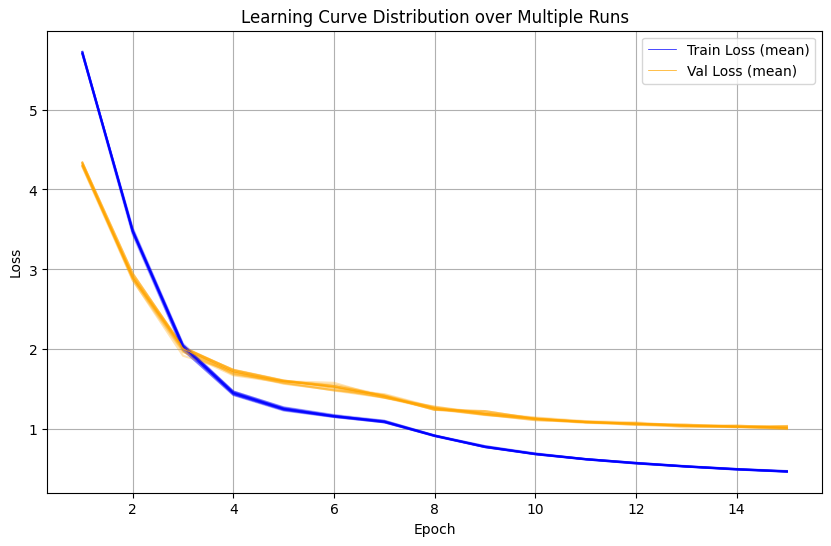

### 시행 2: 7회 반복

    config = {
        "n_layers": 3,
        "d_model": 256,
        "n_heads": 4,
        "d_ff": 1024,
        "dropout": 0.5,
        "vocab_size": 15000,
        "pos_len": 50,
        "batch_size": 32,
        "epochs": 20
    }

    example = ['지루하다, 놀러가고 싶어.',
           '오늘 일찍 일어났더니 피곤하다.',
           '간만에 여자친구랑 데이트 하기로 했어.',
           '집에 있는다는 소리야.',
           '배고픈데 뭐 먹을지 고민되네.',
           '비가 와서 그런가 기분이 좀 별로야.',
           '시험 공부해야 하는데 집중이 안 돼.',
           '드라마 정주행 시작했는데 완전 내 스타일!',
           '운동 갔다 왔더니 몸이 너무 아파.',
           '주말인데 할 일이 너무 많아서 귀찮다.']

    example_answers = ['같이 놀면 좋겠어요',
                   '조금 더 잠 들어요',
                   '즐거운 날이 되겠네요',
                   '방 청소를 하면 되겠네',
                   '뭐라도 드세요',
                   '스트레칭하는 것도 도움 될 거야',
                   '딴 생각 하지 마세요',
                   '드라마 완전 재밌나 봐요',
                   '몸이 놀라서 그래',
                   '주말에도 일 하느라 힘들겠다']
